In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D


In [2]:
#Define constants
m = 39.95*1.68*10**(-27)
epsilon = 119.8/1.381*10**(-23)
sigma = 3.405 #angstrom
h = 10**-4 #Timestep, sqrt(m*sigma**2/epsilon)

#Potential function in natural units
def r(x,y):
    r_pos = np.sqrt(x**2+y**2)
    return r_pos

def Grad_potential(x_1, y_1, x_2, y_2):
    direction = np.array([[x_1 - x_2], [y_1 - y_2]])
    r = np.sqrt((x_1 - x_2)**2+(y_1 - y_2)**2)
    U_partial_r = -4*(6*(r)**(-7) - 12*(r)**(-13))
    grad_U = U_partial_r * direction *r**(-1)
    return grad_U

def boxcheck (x, y):
    x_upper_limit = 5.0 #units of sigma
    y_upper_limit = 5.0 #units of sigma
    
    x_lower_limit = 0
    y_lower_limit = 0
    
    l = x_upper_limit - x_lower_limit #length of the box, only works for squares
    
    if x < x_upper_limit and x > x_lower_limit:
        if y < y_upper_limit and y > y_lower_limit:
            return np.array([x, y])
        if y > y_upper_limit:
            return np.array([x, y -l])
        if y < y_lower_limit:
            return np.array([x, y +l])
    if x > x_upper_limit:
        if ( y < y_upper_limit and y > y_lower_limit):
            return np.array([x- l, y])
        if y > y_upper_limit:
            return np.array([x- l, y - l])
        if y < y_lower_limit:
            return np.array([x- l, y + l])
    if x < x_lower_limit:
        if ( y < y_upper_limit and y > y_lower_limit):
            return np.array([x + l, y])
        if y > y_upper_limit:
            return np.array([x + l, y - l])
        if y < y_lower_limit:
            return np.array([x + l, y + l])

def Force(A_Position,B_Position, L=5):
    Sequence_Polarity = np.array(A_Position>B_Position)*2 -1
    Image_Polarity = np.array(np.power((A_Position-B_Position),2)>(L/2)**(2))
    Distances = (Image_Polarity*L-np.abs(A_Position-B_Position))
    Distance = np.sum(np.power(Distances,2))**(0.5)
    Lennard_Jones_pot = 4*(Distance**(-6) - Distance**(-12))
    Total_Force = 4*(6/(Distance)**(7) - 12/(Distance)**(13))
    Directions = Distances*Sequence_Polarity
    Forces = (Directions/Distance)*Total_Force
    return Forces, Lennard_Jones_pot
        
#Class for argon particles
        
class Particle:
    
    mass = 39.95*1.68*10**(-27)
    def __init__(self, x, y, z, vx, vy, vz):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.z = z
        self.vz = vz

class Energy:
    def __init__(self, E_tot, E_kin, E_pot):
        self.E_tot = E_tot
        self.E_kin = E_kin
        self.E_pot = E_pot

In [ ]:
# Loop to initialize the particles

#Using natural units

L = 5.0 # length of box

particles = []

energy = []
E_kin_initial = np.array([0.0])
E_pot_initial = np.array([0.0])

T = 1 #units epsilon/k_B = 119.8 K, is input of user



rho = 1 #input of user, units of sigma**-3, N*m/L^3


#Positions of atoms
Lattice_Size = 4
T = 1


unit_cell = np.array([[Lattice_Size/2,Lattice_Size/2,Lattice_Size/2],[Lattice_Size,Lattice_Size,Lattice_Size/2],
                      [Lattice_Size,Lattice_Size/2,Lattice_Size],[Lattice_Size/2,Lattice_Size,Lattice_Size]])
pos = np.zeros((4,6))

n_particles = int(np.size(pos)/6)

#Number of cells
Nx = 1
Ny = 1
Nz = 1
Step = 0
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            pos[Step:Step+4,:3] = (unit_cell + np.tile([i,j,k],4).reshape(4,3))
            Velocities = np.zeros((4,3))
            for l in range(int(np.size(unit_cell)/3)):
                vx = np.random.normal(0, np.sqrt(T))
                vy = np.random.normal(0, np.sqrt(T))
                vz = np.random.normal(0, np.sqrt(T))
                Velocities[l,:] = np.array([vx,vy,vz])
                
            
            pos[Step:Step+4,3:] = Velocities
            Step += int(np.size(unit_cell)/3)
            
print(pos)

In [3]:
L=10
Timestep = 0.0001
Iterations = 10000
#pos = L*np.array([[0.1,0.1,1,0.1,0,0],[0.7,0.7,0.7,0,0,0],[1,1,0,0,0,0]])
N_Particles = np.shape(pos)[0]
Dimensions = 3

Historic_Positions = np.zeros((N_Particles,Dimensions,Iterations))
Historic_Velocities = np.zeros((N_Particles,Dimensions,Iterations))
#print(np.shape(Historic_Positions))
Positions = pos[:,:3]
Velocities = pos[:,3:]
Historic_Positions[:,:,0] = Positions
Historic_Velocities[:,:,0] = Velocities

Energy = np.zeros((Iterations,3))
# print(Velocities[:,:])
# print(np.sum(0.5*Velocities[:,:]**2))
#kin, pot, total

for t in range(Iterations-1):
    Energy[t,0] = np.sum(0.5*Velocities[:,:]**2)
    if t == 0:
        Energy[t,1] = 0
    else:
        Energy[t,1] = -np.sum(Pot_En)
    Energy[t,2] = Energy[t,0] + Energy[t,1]
    #print("v",Velocities)
    Forces = np.zeros((N_Particles,Dimensions))
    Pot_En = np.zeros((N_Particles,Dimensions))
    for i in range(N_Particles):
        for j in range(N_Particles):
            if (i != j):
                Added_Forces, LJ_En = Force(Positions[i,:],Positions[j,:])
                Forces[i] += Added_Forces
                Pot_En[i] += LJ_En
                
    Positions = (Historic_Positions[:,:,t] + Velocities*Timestep + Forces*(Timestep**2)/2)%L
    Historic_Positions[:,:,t+1] = Positions
    if (t>0):
        Velocities = Historic_Velocities[:,:,t-1] + (Historic_Forces+Forces)*(Timestep/2)
        Historic_Velocities[:,:,t] = Velocities
    Historic_Forces = Forces
#     plt.scatter(Positions[:,0],Positions[:,1])
#     plt.xlim(0,L)
#     plt.ylim(0,L)
#     plt.show()
#     clear_output(wait=True)

[[ 2.          2.          2.          0.19331268 -1.47351542 -0.19158882]
 [ 4.          4.          2.         -0.44535435  0.59016526  0.67420753]
 [ 4.          2.          4.          2.4409846  -1.1638442  -0.8218931 ]
 [ 2.          4.          4.          1.12051082  0.32113338 -0.3757049 ]]


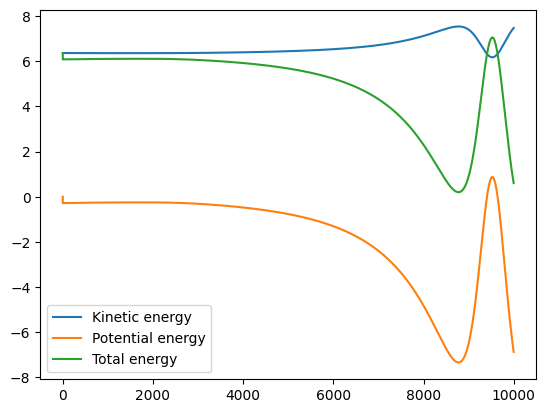

In [4]:
plt.plot(Energy[0:-1,0], label = 'Kinetic energy')
plt.plot(Energy[0:-1,1], label = 'Potential energy')
plt.plot(Energy[0:-1,2], label = 'Total energy')
plt.legend()

<class 'numpy.ndarray'>


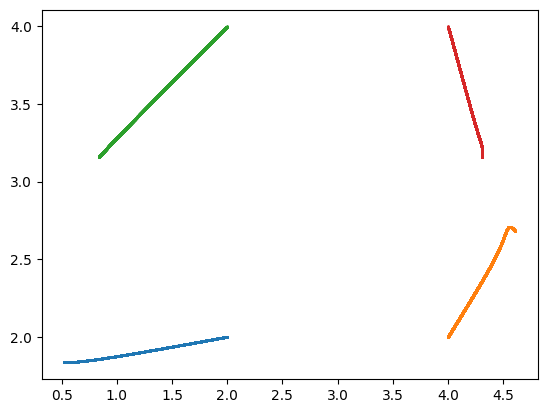

In [5]:
plt.scatter(Historic_Positions[0,1,:], Historic_Positions[0,2,:], s = 0.5)
plt.scatter(Historic_Positions[1,1,:], Historic_Positions[1,2,:], s = 0.5)
plt.scatter(Historic_Positions[2,1,:], Historic_Positions[2,2,:], s = 0.5)
plt.scatter(Historic_Positions[3,1,:], Historic_Positions[2,2,:], s = 0.5)


Historic_Positions[:,:,0]

print(type(Historic_Positions))

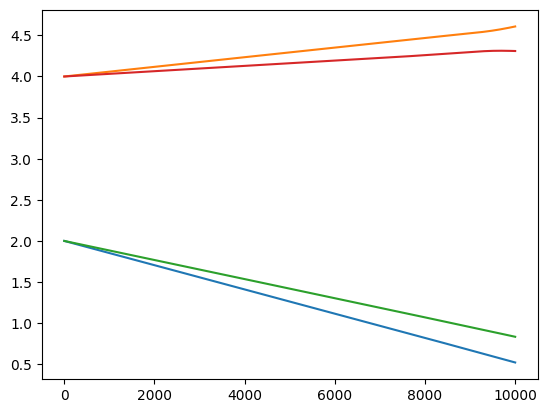

In [6]:
plt.plot(Historic_Positions[0,1,:])
plt.plot(Historic_Positions[1,1,:])
plt.plot(Historic_Positions[2,1,:])
plt.plot(Historic_Positions[3,1,:])

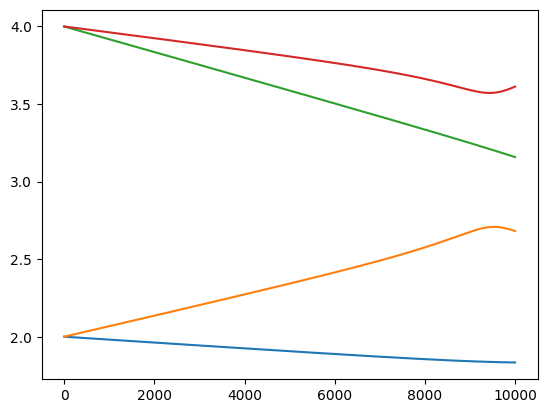

In [7]:
plt.plot(Historic_Positions[0,2,:])
plt.plot(Historic_Positions[1,2,:])
plt.plot(Historic_Positions[2,2,:])
plt.plot(Historic_Positions[3,2,:])

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


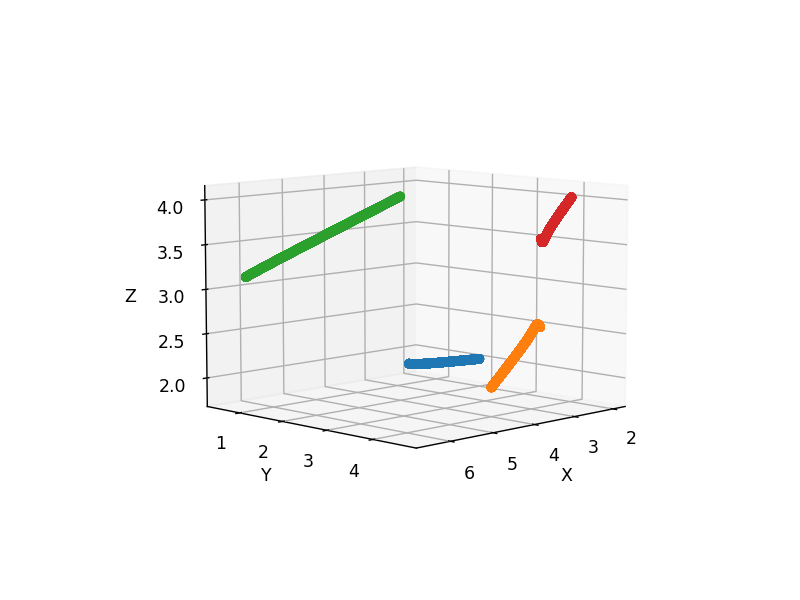

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for l in range(n_particles):
    ax.scatter(Historic_Positions[l,0,:],Historic_Positions[l,1,:], Historic_Positions[l,2,:])

ax.view_init(elev=8., azim=45.)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()